In [ ]:
import os
import shutil
import pandas as pd
import random
import cv2
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import ast  # For safely evaluating string representation of lists

# Paths
main_dir = r"D:\OCR_Final"
images_dir = os.path.join(main_dir, "train_val_images", "train_images")
annot_file = os.path.join(main_dir, "annot.csv")
cleaned_annot_file = os.path.join(main_dir, "cleaned_annot.csv")
train_dir = os.path.join(main_dir, "train")
test_dir = os.path.join(main_dir, "test")

# Create train and test directories
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

In [3]:
# CB2
# Load annotations
print("Loading annotations...")
annotations = pd.read_csv(annot_file)

# Convert bbox string to list if it's not already
def parse_bbox(bbox_str):
    if isinstance(bbox_str, str):
        return ast.literal_eval(bbox_str)
    return bbox_str

annotations['bbox'] = annotations['bbox'].apply(parse_bbox)

# Get unique image IDs with captions
image_ids_with_captions = annotations['image_id'].unique()

# List all images in the directory
all_images = [f.split(".")[0] for f in os.listdir(images_dir) if f.endswith(('.jpg', '.png'))]
print(f"Total images in directory: {len(all_images)}")

# Identify images with and without captions
images_with_captions = [img for img in all_images if img in image_ids_with_captions]
images_without_captions = [img for img in all_images if img not in image_ids_with_captions]
print(f"Images with captions: {len(images_with_captions)}")
print(f"Images without captions: {len(images_without_captions)}")

Loading annotations...
Total images in directory: 25119
Images with captions: 21778
Images without captions: 3341


In [4]:
#cb 3
# Remove images without captions
print("Removing images without captions...")
for img in images_without_captions:
    img_path = os.path.join(images_dir, f"{img}.jpg")
    if os.path.exists(img_path):
        os.remove(img_path)
print("Images without captions removed.")

# Keep only 1,100 images in the folder
images_with_captions = images_with_captions[:1100]
print(f"Reducing to 1,100 images...")
for img in all_images:
    if img not in images_with_captions:
        img_path = os.path.join(images_dir, f"{img}.jpg")
        if os.path.exists(img_path):
            os.remove(img_path)
print("Folder reduced to 1,100 images.")

# Filter annotations for the 1,100 images
print("Filtering annotations for the 1,100 images...")
annotations = annotations[annotations['image_id'].isin(images_with_captions)]

# Clean captions
print("Cleaning captions (removing invalid entries like `.`)...")
initial_captions_count = len(annotations)
annotations['utf8_string'] = annotations['utf8_string'].apply(
    lambda x: x.strip() if isinstance(x, str) else x
)
annotations = annotations[~annotations['utf8_string'].isin(['.', ',', '!', '?', None, ''])]
final_captions_count = len(annotations)
print(f"Removed {initial_captions_count - final_captions_count} invalid captions.")

Removing images without captions...
Images without captions removed.
Reducing to 1,100 images...
Folder reduced to 1,100 images.
Filtering annotations for the 1,100 images...
Cleaning captions (removing invalid entries like `.`)...
Removed 13884 invalid captions.


In [5]:
#cb4
def calculate_image_transformations(image_path, desired_size=512):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    old_size = img.shape[:2]  # (height, width)
    ratio = float(desired_size) / max(old_size)
    new_size = tuple([int(x * ratio) for x in old_size])
    
    delta_w = desired_size - new_size[1]
    delta_h = desired_size - new_size[0]
    padding_left = delta_w // 2
    padding_top = delta_h // 2
    
    return ratio, padding_top, padding_left, img

def transform_bbox(bbox, ratio, padding_top, padding_left):
    # bbox format: [x, y, width, height]
    x, y, width, height = bbox
    
    # Transform coordinates
    x_new = int(x * ratio) + padding_left
    y_new = int(y * ratio) + padding_top
    width_new = int(width * ratio)
    height_new = int(height * ratio)
    
    return [x_new, y_new, width_new, height_new]

def preprocess_image(image_path, save_path, image_annotations=None):
    # Calculate transformations
    ratio, padding_top, padding_left, img = calculate_image_transformations(image_path)
    
    # Resize image
    desired_size = 512
    old_size = img.shape[:2]
    new_size = tuple([int(x * ratio) for x in old_size])
    resized = cv2.resize(img, (new_size[1], new_size[0]))
    
    # Add padding
    delta_w = desired_size - new_size[1]
    delta_h = desired_size - new_size[0]
    top, bottom = delta_h // 2, delta_h - (delta_h // 2)
    left, right = delta_w // 2, delta_w - (delta_w // 2)
    
    padded = cv2.copyMakeBorder(resized, top, bottom, left, right, cv2.BORDER_CONSTANT, value=0)
    
    # Apply CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(padded)
    
    # Save the preprocessed image
    cv2.imwrite(save_path, enhanced)
    
    # Transform bounding boxes if annotations are provided
    if image_annotations is not None:
        # Transform each bbox
        transformed_bboxes = image_annotations['bbox'].apply(
            lambda x: transform_bbox(x, ratio, padding_top, padding_left)
        )
        return transformed_bboxes
    
    return None

In [ ]:
#cb5
# Process images and transform annotations
print("Preprocessing images and transforming bounding boxes...")
transformed_annotations_list = []
preprocessed_images = []  # Keep track of successfully processed images

for img_id in images_with_captions:
    src_path = os.path.join(images_dir, f"{img_id}.jpg")
    if os.path.exists(src_path):
        # Get annotations for this image
        img_annotations = annotations[annotations['image_id'] == img_id].copy()
        
        # Preprocess image and transform bounding boxes
        transformed_bbox = preprocess_image(src_path, src_path, img_annotations)
        
        if transformed_bbox is not None:
            # Update bounding boxes
            img_annotations['bbox'] = transformed_bbox
            transformed_annotations_list.append(img_annotations)
            preprocessed_images.append(img_id)

# Combine all transformed annotations
transformed_annotations = pd.concat(transformed_annotations_list, axis=0)

# Save transformed annotations
print(f"Saving {len(transformed_annotations)} transformed annotations to {cleaned_annot_file}")
transformed_annotations.to_csv(cleaned_annot_file, index=False)

# Print sample for verification
print("\nSample of original vs transformed coordinates:")
original_sample = annotations.iloc[:5][['image_id', 'bbox', 'utf8_string']]
transformed_sample = transformed_annotations.iloc[:5][['image_id', 'bbox', 'utf8_string']]
print("\nOriginal coordinates:")
print(original_sample)
print("\nTransformed coordinates:")
print(transformed_sample)

Preprocessing images and transforming bounding boxes...
Saving 25928 transformed annotations to D:\OCR_Final\cleaned_annot.csv

Sample of original vs transformed coordinates:

Original coordinates:
             image_id                             bbox utf8_string
85   00c359f294f7dcd9  [322.37, 368.64, 118.63, 51.07]      G-ATCO
86   00c359f294f7dcd9   [865.36, 322.28, 33.92, 11.57]       HUSKY
87   00c359f294f7dcd9   [150.68, 313.56, 19.87, 18.85]           +
156  01ee1b7395e1d8c4   [502.03, 194.97, 57.56, 53.96]          MI
157  01ee1b7395e1d8c4   [547.45, 214.76, 142.54, 61.6]       ÚJSÁG

Transformed coordinates:
                image_id                bbox utf8_string
761457  0000e8b36676338b   [154, 152, 22, 8]       FELIX
761458  0000e8b36676338b  [191, 155, 35, 10]      PRIVAT
761459  0000e8b36676338b   [68, 316, 17, 12]         DBU
761460  0000e8b36676338b   [87, 320, 17, 13]         889
684409  00010bf498b64bab   [94, 238, 35, 23]        TEQU



Displaying verification for first image...

Transformed Bounding Box Coordinates:
Text: 3G
Coordinates: [114, 41, 11, 8]
Text: Applications
Coordinates: [131, 10, 106, 21]
Text: 12:15
Coordinates: [325, 23, 30, 11]
Text: LightSabre
Coordinates: [125, 137, 64, 16]
Text: ScreenSnap
Coordinates: [210, 138, 69, 15]
Text: Adobe
Coordinates: [125, 233, 38, 14]
Text: PDF
Coordinates: [167, 233, 22, 13]
Text: Touch
Coordinates: [205, 233, 37, 13]
Text: Guitar
Coordinates: [247, 233, 37, 13]
Text: UpCode
Coordinates: [135, 329, 45, 16]
Text: Zip
Coordinates: [235, 330, 18, 15]
Text: Tfl
Coordinates: [149, 402, 15, 8]
Text: Tfl
Coordinates: [134, 425, 18, 14]
Text: Map
Coordinates: [156, 426, 24, 15]
Text: WinRaR
Coordinates: [221, 426, 47, 14]
Text: Options
Coordinates: [117, 478, 63, 21]
Text: Back
Coordinates: [355, 477, 39, 18]
Text: Sports
Coordinates: [292, 138, 39, 15]
Text: Trac...
Coordinates: [334, 138, 37, 12]
Text: Touch
Coordinates: [294, 233, 38, 13]
Text: Piano
Coordinates: [335,

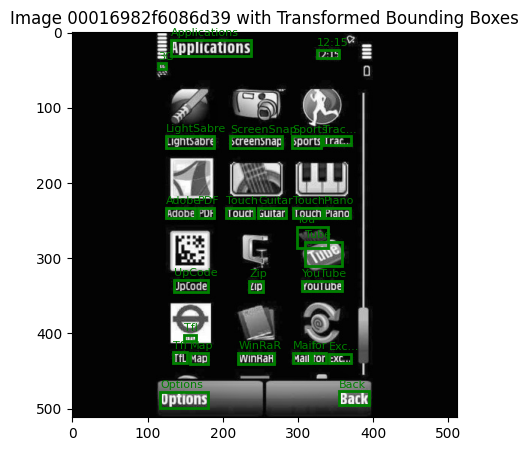

In [7]:
#cb6

def verify_bbox_transformation(image_id, annotations, transformed_annotations, images_dir):
    """
    Display an image with its original and transformed bounding boxes for verification.
    """
    img_path = os.path.join(images_dir, f"{image_id}.jpg")
    if not os.path.exists(img_path):
        print(f"Image {image_id} not found")
        return
    
    # Load the preprocessed image
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    
    # Get annotations for this image
    trans_annotations = transformed_annotations[transformed_annotations['image_id'] == image_id]
    
    # Create figure
    plt.figure(figsize=(15, 5))
    
    # Plot details
    plt.imshow(img_rgb)
    
    # Draw transformed bounding boxes in green
    for _, row in trans_annotations.iterrows():
        bbox = row['bbox']
        x, y, w, h = bbox
        plt.gca().add_patch(plt.Rectangle((x, y), w, h,
                                        fill=False, color='green', linewidth=2))
        # Add text near the bounding box
        plt.text(x, y-5, row['utf8_string'], color='green', fontsize=8)
    
    plt.title(f'Image {image_id} with Transformed Bounding Boxes')
    plt.axis('on')  # Show axis for coordinate verification
    
    # Print coordinates for verification
    print("\nTransformed Bounding Box Coordinates:")
    for _, row in trans_annotations.iterrows():
        print(f"Text: {row['utf8_string']}")
        print(f"Coordinates: {row['bbox']}")
    
    plt.show()

# Verify transformation for first image
print("\nDisplaying verification for first image...")
first_image_id = preprocessed_images[2]
verify_bbox_transformation(first_image_id, annotations, transformed_annotations, images_dir)

In [8]:
#cb7
# Shuffle and split into train and test sets (90.9% - 9.1% split for 1000-100)
print("\nSplitting images into train and test sets...")
random.shuffle(preprocessed_images)
train_images = preprocessed_images[:1000]
test_images = preprocessed_images[1000:]

# Move images to train and test folders
print("Moving images to train and test folders...")
for img_id in train_images:
    src = os.path.join(images_dir, f"{img_id}.jpg")
    dest = os.path.join(train_dir, f"{img_id}.jpg")
    if os.path.exists(src):
        shutil.move(src, dest)

for img_id in test_images:
    src = os.path.join(images_dir, f"{img_id}.jpg")
    dest = os.path.join(test_dir, f"{img_id}.jpg")
    if os.path.exists(src):
        shutil.move(src, dest)

print("\nTrain-Test Split Completed:")
print(f"Train images: {len(train_images)}")
print(f"Test images: {len(test_images)}")


Splitting images into train and test sets...
Moving images to train and test folders...

Train-Test Split Completed:
Train images: 1000
Test images: 100


Loading annotations...
Processing training images...


C:\Users\guruk\AppData\Local\Temp\ipykernel_16692\2936379412.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  annotations_df['bbox'] = annotations_df['bbox'].apply(parse_bbox)
100%|██████████| 1000/1000 [02:56<00:00,  5.66it/s]
C:\Users\guruk\AppData\Local\Temp\ipykernel_16692\2936379412.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  annotations_df['bbox'] = annotations_df['bbox'].apply(parse_bbox)



Processing Summary:
Total processed: 18223
Skipped (too small): 5482
Saved 18223 training crops
Processing test images...


100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Processing Summary:
Total processed: 1599
Skipped (too small): 624
Saved 1599 test crops

Verifying random training crops:


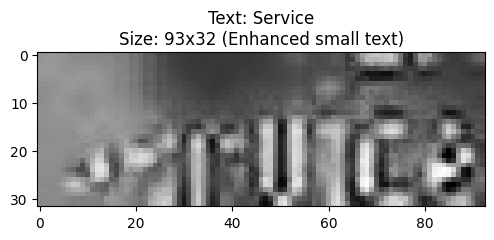

Original dimensions: 32x11
Resized dimensions: 93x32
--------------------------------------------------


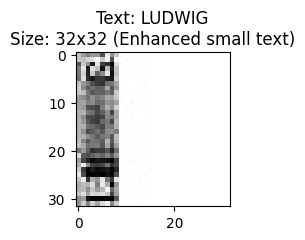

Original dimensions: 12x40
Resized dimensions: 32x32
--------------------------------------------------


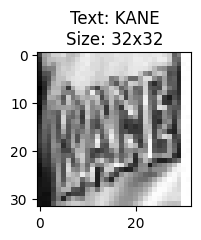

Original dimensions: 35x37
Resized dimensions: 32x32
--------------------------------------------------


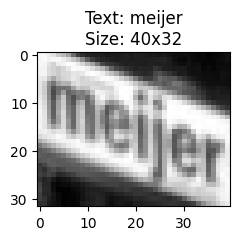

Original dimensions: 74x58
Resized dimensions: 40x32
--------------------------------------------------

Verifying random test crops:


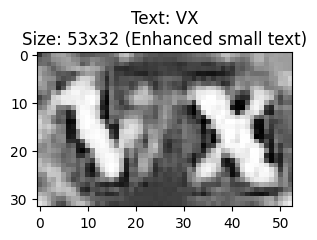

Original dimensions: 25x15
Resized dimensions: 53x32
--------------------------------------------------


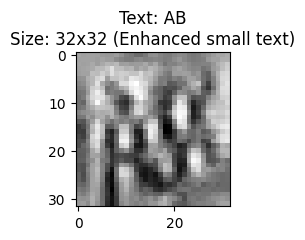

Original dimensions: 11x11
Resized dimensions: 32x32
--------------------------------------------------


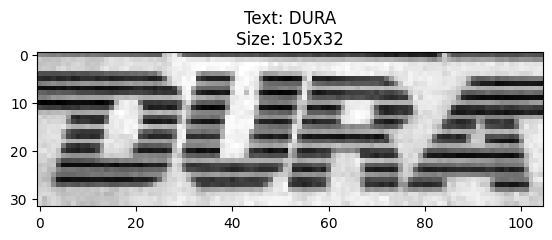

Original dimensions: 149x45
Resized dimensions: 105x32
--------------------------------------------------


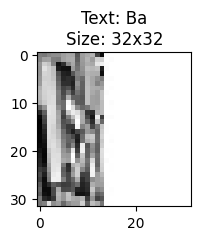

Original dimensions: 90x193
Resized dimensions: 32x32
--------------------------------------------------

Dataset Statistics:
Training Set:
is_small
True     16949
False     1274
Name: count, dtype: int64

Test Set:
is_small
True     1457
False     142
Name: count, dtype: int64


In [9]:
#cb8
import os
import cv2
import pandas as pd
from tqdm import tqdm
import ast  # For safely evaluating string representation of lists
from matplotlib import pyplot as plt
import numpy as np

# Create directories for cropped images
cropped_train_dir = os.path.join(main_dir, "cropped_train")
cropped_test_dir = os.path.join(main_dir, "cropped_test")
os.makedirs(cropped_train_dir, exist_ok=True)
os.makedirs(cropped_test_dir, exist_ok=True)

def parse_bbox(bbox):
    """Convert bbox string to list of coordinates"""
    if isinstance(bbox, str):
        return ast.literal_eval(bbox)
    return bbox

def enhance_small_image(image, target_height):
    """
    Apply enhancement techniques for small images
    """
    # Apply bilateral filter to reduce noise while preserving edges
    denoised = cv2.bilateralFilter(image, 9, 75, 75)
    
    # Resize with cubic interpolation for better quality
    resized = cv2.resize(denoised, (int(target_height * image.shape[1]/image.shape[0]), target_height), 
                        interpolation=cv2.INTER_CUBIC)
    
    # Apply sharpening
    kernel = np.array([[-1,-1,-1],
                      [-1, 9,-1],
                      [-1,-1,-1]])
    sharpened = cv2.filter2D(resized, -1, kernel)
    
    # Enhance contrast with CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(2, 2))
    enhanced = clahe.apply(sharpened)
    
    # Final denoising
    final = cv2.fastNlMeansDenoising(enhanced, None, 10, 7, 21)
    
    return final

def crop_text_regions(image_dir, output_dir, annotations_df, target_height=32, min_area=50):
    """
    Crop text regions from images and save them with standardized size
    """
    cropped_annotations = []
    skipped_small = 0
    processed_count = 0
    
    # Ensure bbox is in the correct format
    annotations_df['bbox'] = annotations_df['bbox'].apply(parse_bbox)
    
    # Group annotations by image_id
    grouped_annotations = annotations_df.groupby('image_id')
    
    for image_id, group in tqdm(grouped_annotations):
        # Read the image
        image_path = os.path.join(image_dir, f"{image_id}.jpg")
        if not os.path.exists(image_path):
            print(f"Image not found: {image_path}")
            continue
            
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            print(f"Failed to read image: {image_path}")
            continue
        
        # Process each text region in the image
        for idx, row in group.iterrows():
            try:
                # Get bbox coordinates
                bbox = row['bbox']
                if len(bbox) != 4:
                    print(f"Invalid bbox for {image_id}: {bbox}")
                    continue
                    
                x, y, w, h = bbox
                
                # Ensure coordinates are integers
                x, y, w, h = map(int, map(float, [x, y, w, h]))
                
                # Skip extremely small regions
                if w * h < min_area:
                    skipped_small += 1
                    continue
                
                # Crop the region
                cropped = img[y:y+h, x:x+w]
                
                # Skip if cropped region is empty
                if cropped.size == 0:
                    print(f"Empty crop for {image_id} at {bbox}")
                    continue
                
                # Process based on size
                is_small = w < target_height or h < target_height
                
                if is_small:
                    # Apply enhanced processing for small images
                    resized = enhance_small_image(cropped, target_height)
                else:
                    # Normal processing for larger images
                    aspect_ratio = w / h
                    target_width = int(target_height * aspect_ratio)
                    resized = cv2.resize(cropped, (target_width, target_height), 
                                       interpolation=cv2.INTER_AREA)
                    # Apply basic CLAHE
                    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(2, 2))
                    resized = clahe.apply(resized)
                
                # Ensure minimum width and add padding if needed
                if resized.shape[1] < target_height:
                    padding = target_height - resized.shape[1]
                    resized = cv2.copyMakeBorder(resized, 0, 0, 0, padding,
                                               cv2.BORDER_CONSTANT, value=255)
                
                # Create unique filename for cropped image
                crop_filename = f"{image_id}_{idx}.jpg"
                crop_path = os.path.join(output_dir, crop_filename)
                
                # Save cropped image
                cv2.imwrite(crop_path, resized)
                
                # Store annotation
                cropped_annotations.append({
                    'crop_id': f"{image_id}_{idx}",
                    'original_image_id': image_id,
                    'crop_filename': crop_filename,
                    'text': row['utf8_string'],
                    'original_width': w,
                    'original_height': h,
                    'resized_width': resized.shape[1],
                    'resized_height': resized.shape[0],
                    'is_small': is_small
                })
                
                processed_count += 1
                
            except Exception as e:
                print(f"Error processing {image_id}: {str(e)}")
                continue
    
    print(f"\nProcessing Summary:")
    print(f"Total processed: {processed_count}")
    print(f"Skipped (too small): {skipped_small}")
    
    return pd.DataFrame(cropped_annotations)

# Read the cleaned annotations
print("Loading annotations...")
annotations = pd.read_csv(cleaned_annot_file)

# Split annotations into train and test based on image_ids
train_annotations = annotations[annotations['image_id'].isin(train_images)]
test_annotations = annotations[annotations['image_id'].isin(test_images)]

# Crop and save training images
print("Processing training images...")
train_crops_df = crop_text_regions(train_dir, cropped_train_dir, train_annotations)
train_crops_df.to_csv(os.path.join(main_dir, 'cropped_train_annotations.csv'), index=False)
print(f"Saved {len(train_crops_df)} training crops")

# Crop and save test images
print("Processing test images...")
test_crops_df = crop_text_regions(test_dir, cropped_test_dir, test_annotations)
test_crops_df.to_csv(os.path.join(main_dir, 'cropped_test_annotations.csv'), index=False)
print(f"Saved {len(test_crops_df)} test crops")

# Verify random crops with additional information
def verify_random_crops(crops_df, crops_dir, num_samples=5):
    # Get some small and some normal samples
    small_samples = crops_df[crops_df['is_small']].sample(n=min(num_samples//2, len(crops_df[crops_df['is_small']])))
    normal_samples = crops_df[~crops_df['is_small']].sample(n=min(num_samples//2, len(crops_df[~crops_df['is_small']])))
    sample_crops = pd.concat([small_samples, normal_samples])
    
    for _, row in sample_crops.iterrows():
        crop_path = os.path.join(crops_dir, row['crop_filename'])
        if os.path.exists(crop_path):
            crop = cv2.imread(crop_path, cv2.IMREAD_GRAYSCALE)
            plt.figure(figsize=(10, 2))
            plt.imshow(crop, cmap='gray')
            title = f"Text: {row['text']}\nSize: {crop.shape[1]}x{crop.shape[0]}"
            if row['is_small']:
                title += " (Enhanced small text)"
            plt.title(title)
            plt.axis('on')
            plt.show()
            print(f"Original dimensions: {row['original_width']}x{row['original_height']}")
            print(f"Resized dimensions: {row['resized_width']}x{row['resized_height']}")
            print("-" * 50)

print("\nVerifying random training crops:")
verify_random_crops(train_crops_df, cropped_train_dir)

print("\nVerifying random test crops:")
verify_random_crops(test_crops_df, cropped_test_dir)

# Print overall statistics
print("\nDataset Statistics:")
print("Training Set:")
print(train_crops_df['is_small'].value_counts())
print("\nTest Set:")
print(test_crops_df['is_small'].value_counts())

In [10]:
#cb9
import numpy as np
import pickle
import json
from collections import Counter
print("Starting Text Tokenization...")

class TextTokenizer:
    def __init__(self):
        # Special tokens
        self.pad_token = '<PAD>'
        self.unk_token = '<UNK>'
        self.blank_token = '<BLANK>'  # For CTC
        self.start_token = '<START>'  # Optional: for seq2seq models
        self.end_token = '<END>'      # Optional: for seq2seq models
        
        # Initialize dictionaries
        self.char_to_idx = {}
        self.idx_to_char = {}
        self.vocab_size = 0
        
    def fit(self, texts):
        # Get unique characters from all texts
        chars = set()
        char_counter = Counter()
        
        print("Analyzing text data...")
        for text in texts:
            # Convert to string and clean
            text = str(text).strip()
            if text:  # Only process non-empty texts
                chars.update(set(text))
                char_counter.update(text)
        
        # Sort characters by frequency
        chars = sorted(list(chars))
        
        print(f"Found {len(chars)} unique characters")
        
        # Create mappings with special tokens
        self.char_to_idx = {
            self.blank_token: 0,  # CTC blank token
            self.pad_token: 1,    # Padding token
            self.unk_token: 2,    # Unknown character token
            self.start_token: 3,  # Start token
            self.end_token: 4,    # End token
        }
        
        # Add characters to mapping
        for i, char in enumerate(chars):
            self.char_to_idx[char] = i + 5  # +5 for special tokens
            
        # Create reverse mapping
        self.idx_to_char = {v: k for k, v in self.char_to_idx.items()}
        self.vocab_size = len(self.char_to_idx)
        
        # Print character frequency statistics
        print("\nCharacter frequency distribution:")
        for char, count in char_counter.most_common(10):
            print(f"'{char}': {count}")
            
    def encode(self, text, max_length=None, add_special_tokens=True):
        # Convert text to sequence of indices
        text = str(text).strip()
        sequence = []
        
        if add_special_tokens:
            sequence.append(self.char_to_idx[self.start_token])
            
        sequence.extend([self.char_to_idx.get(char, self.char_to_idx[self.unk_token]) 
                        for char in text])
        
        if add_special_tokens:
            sequence.append(self.char_to_idx[self.end_token])
        
        if max_length is not None:
            # Pad sequence if needed
            if len(sequence) < max_length:
                sequence += [self.char_to_idx[self.pad_token]] * (max_length - len(sequence))
            else:
                sequence = sequence[:max_length]
                
        return sequence
    
    def decode(self, sequence, remove_special_tokens=True):
        # Convert sequence of indices back to text
        text = []
        for idx in sequence:
            if idx in self.idx_to_char:
                char = self.idx_to_char[idx]
                if remove_special_tokens:
                    if char not in [self.pad_token, self.blank_token, 
                                  self.start_token, self.end_token]:
                        text.append(char)
                else:
                    text.append(char)
        return ''.join(text)
    
    def save(self, filepath):
        # Save tokenizer configuration
        config = {
            'char_to_idx': self.char_to_idx,
            'idx_to_char': self.idx_to_char,
            'vocab_size': self.vocab_size
        }
        with open(filepath, 'wb') as f:
            pickle.dump(config, f)
        print(f"Tokenizer saved to: {filepath}")
    
    @classmethod
    def load(cls, filepath):
        # Load tokenizer configuration
        with open(filepath, 'rb') as f:
            config = pickle.load(f)
        
        tokenizer = cls()
        tokenizer.char_to_idx = config['char_to_idx']
        tokenizer.idx_to_char = config['idx_to_char']
        tokenizer.vocab_size = config['vocab_size']
        return tokenizer

# Load the cropped annotations
print("Loading cropped annotations...")
train_crops_df = pd.read_csv(os.path.join(main_dir, 'cropped_train_annotations.csv'))
test_crops_df = pd.read_csv(os.path.join(main_dir, 'cropped_test_annotations.csv'))

# Create and train tokenizer
print("Creating tokenizer...")
tokenizer = TextTokenizer()
all_texts = list(train_crops_df['text']) + list(test_crops_df['text'])
tokenizer.fit(all_texts)

# Find maximum text length for padding
max_length = max(len(str(text)) for text in all_texts)
print(f"Maximum text length (without special tokens): {max_length}")
max_length += 2  # Add space for start and end tokens

# Tokenize annotations
def tokenize_dataframe(df, tokenizer, max_length):
    print(f"Processing {len(df)} texts...")
    df['encoded_text'] = df['text'].apply(lambda x: tokenizer.encode(x, max_length))
    df['text_length'] = df['text'].apply(lambda x: len(str(x)))
    return df

# Process train and test sets
print("\nTokenizing training data...")
train_crops_df = tokenize_dataframe(train_crops_df, tokenizer, max_length)
print("Tokenizing test data...")
test_crops_df = tokenize_dataframe(test_crops_df, tokenizer, max_length)

# Save tokenizer
tokenizer_path = os.path.join(main_dir, 'tokenizer.pkl')
tokenizer.save(tokenizer_path)

# Save processed annotations
train_crops_df.to_csv(os.path.join(main_dir, 'cropped_train_annotations.csv'), index=False)
test_crops_df.to_csv(os.path.join(main_dir, 'cropped_test_annotations.csv'), index=False)

# Verify tokenization
print("\nVerifying tokenization with examples:")
for i in range(5):  # Show 5 random examples
    sample_text = train_crops_df['text'].iloc[i]
    encoded = tokenizer.encode(sample_text)
    decoded = tokenizer.decode(encoded)
    print(f"\nOriginal : {sample_text}")
    print(f"Encoded  : {encoded}")
    print(f"Decoded  : {decoded}")
    print(f"Matches  : {sample_text == decoded}")

# Print tokenizer statistics
print("\nTokenizer Statistics:")
print(f"Vocabulary size: {tokenizer.vocab_size}")
print(f"Maximum sequence length: {max_length}")
print("\nSpecial tokens:")
for token in [tokenizer.pad_token, tokenizer.unk_token, tokenizer.blank_token, 
              tokenizer.start_token, tokenizer.end_token]:
    print(f"{token}: {tokenizer.char_to_idx[token]}")

# Save vocab as text for reference
vocab_path = os.path.join(main_dir, 'vocabulary.txt')
with open(vocab_path, 'w', encoding='utf-8') as f:
    f.write("Index\tCharacter\n")
    for idx in range(tokenizer.vocab_size):
        char = tokenizer.idx_to_char[idx]
        f.write(f"{idx}\t{char}\n")
print(f"\nVocabulary saved to: {vocab_path}")

Starting Text Tokenization...
Loading cropped annotations...
Creating tokenizer...
Analyzing text data...
Found 232 unique characters

Character frequency distribution:
'e': 5467
'E': 4721
'A': 4197
'a': 3826
'o': 3561
'i': 3397
'R': 3363
'S': 3356
'O': 3342
'n': 3328
Maximum text length (without special tokens): 42

Tokenizing training data...
Processing 18223 texts...
Tokenizing test data...
Processing 1599 texts...
Tokenizer saved to: D:\OCR_Final\tokenizer.pkl

Verifying tokenization with examples:

Original : FELIX
Encoded  : [3, 42, 41, 48, 45, 60, 4]
Decoded  : FELIX
Matches  : True

Original : PRIVAT
Encoded  : [3, 52, 54, 45, 58, 37, 56, 4]
Decoded  : PRIVAT
Matches  : True

Original : DBU
Encoded  : [3, 40, 38, 57, 4]
Decoded  : DBU
Matches  : True

Original : 889
Encoded  : [3, 28, 28, 29, 4]
Decoded  : 889
Matches  : True

Original : TEQU
Encoded  : [3, 56, 41, 53, 57, 4]
Decoded  : TEQU
Matches  : True

Tokenizer Statistics:
Vocabulary size: 237
Maximum sequence length: 44

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CRNN(nn.Module):
    def __init__(self, num_chars, img_height=32, hidden_size=128):
        super().__init__()
        
        # CNN layers - Simplified and effective architecture
        self.cnn = nn.Sequential(
            # First layer
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),  # Height: 32 -> 16
            
            # Second layer
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),  # Height: 16 -> 8
            
            # Third layer
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            
            # Fourth layer
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d((2, 1), (2, 1)),  # Height: 8 -> 4, width preserved
            
            # Fifth layer
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            
            # Dropout
            nn.Dropout2d(0.2)
        )
        
        # Calculate features per time step
        self.features_per_time_step = 256 * (img_height // 8)
        
        # Bidirectional GRU - single layer with moderate dropout
        self.rnn = nn.GRU(
            input_size=self.features_per_time_step,
            hidden_size=hidden_size,
            num_layers=1,
            bidirectional=True,
            batch_first=True,
            dropout=0.2
        )
        
        # Classifier with dropout
        self.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(hidden_size * 2, num_chars)
        )
        
        # Initialize weights
        self._initialize_weights()
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                # Kaiming initialization for ReLU
                nn.init.kaiming_normal_(m.weight, mode='fan_out', 
                                      nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                # Standard initialization for BatchNorm
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                # Xavier initialization for linear layers
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.GRU):
                # Orthogonal initialization for GRU
                for name, param in m.named_parameters():
                    if 'weight' in name:
                        nn.init.orthogonal_(param)
                    elif 'bias' in name:
                        nn.init.constant_(param, 0)
    
    def forward(self, x):
        # CNN feature extraction
        conv = self.cnn(x)
        batch_size, channels, height, width = conv.size()
        
        # Prepare for sequence processing
        # Collapse height and channels into features
        conv = conv.permute(0, 3, 1, 2)  # [batch, width, channels, height]
        conv = conv.contiguous().view(batch_size, width, channels * height)
        
        # RNN sequence processing
        rnn_output, _ = self.rnn(conv)
        
        # Classification
        output = self.classifier(rnn_output)
        
        # Log softmax for CTC loss
        return F.log_softmax(output, dim=2)

# Create the model
print("Creating CRNN model...")
crnn_model = CRNN(num_chars=tokenizer.vocab_size, img_height=32, hidden_size=128)

# Print model summary
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

total_params = count_parameters(crnn_model)
print(f"\nModel Parameters: {total_params:,}")

# Save model architecture for reference
model_summary = os.path.join(main_dir, 'model_architecture.txt')
with open(model_summary, 'w') as f:
    def print_and_write(text):
        print(text)
        f.write(text + '\n')
    
    print_and_write("\nCRNN Architecture Details:")
    print_and_write("-" * 50)
    print_and_write(f"Input Height: {crnn_model.features_per_time_step}")
    print_and_write(f"Hidden Size: {crnn_model.rnn.hidden_size}")
    print_and_write(f"Vocabulary Size: {tokenizer.vocab_size}")
    print_and_write(f"Total Parameters: {total_params:,}")

print(f"\nModel architecture saved to: {model_summary}")

Creating CRNN model...

Model Parameters: 1,483,821

CRNN Architecture Details:
--------------------------------------------------
Input Height: 1024
Hidden Size: 128
Vocabulary Size: 237
Total Parameters: 1,483,821

Model architecture saved to: D:\OCR_Final\model_architecture.txt


c:\Python\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn import CTCLoss
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from torch.nn.utils.rnn import pad_sequence
from PIL import Image
import numpy as np
from pathlib import Path
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
from datetime import datetime
import os

# Configuration with optimized parameters
config = {
    'batch_size': 4,          # Smaller batch size
    'num_workers': 0,         # No parallel loading for CPU
    'epochs': 50,             # More epochs
    'lr': 1e-4,              # Lower learning rate
    'device': 'cpu',
    'early_stopping_patience': 7,
    'train_subset_size': 200, # Start with smaller dataset
    'test_subset_size': 20,
    'image_height': 32,
    'min_lr': 1e-6
}

class OCRDataset(Dataset):
    def __init__(self, annotations_df, img_dir, tokenizer, max_samples=None, image_height=32):
        if max_samples is not None:
            self.annotations = annotations_df.head(max_samples)
        else:
            self.annotations = annotations_df
        self.img_dir = img_dir
        self.tokenizer = tokenizer
        self.image_height = image_height
        
    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self, idx):
        try:
            row = self.annotations.iloc[idx]
            img_path = os.path.join(self.img_dir, row['crop_filename'])
            image = Image.open(img_path).convert('L')  # Ensure grayscale
            
            # Resize maintaining aspect ratio
            w, h = image.size
            new_width = int(w * (self.image_height / h))
            image = image.resize((new_width, self.image_height), Image.BILINEAR)
            
            # Convert to numpy array and normalize
            image = np.array(image).astype(np.float32)
            mean = np.mean(image)
            std = np.std(image) + 1e-6
            image = (image - mean) / std  # z-score normalization
            
            # Add channel dimension
            image = np.expand_dims(image, axis=0)
            image = torch.FloatTensor(image)
            
            # Clean and encode text
            text = str(row['text']).strip()
            text = ''.join(c for c in text if c.isprintable())  # Remove non-printable chars
            
            encoded = self.tokenizer.encode(text)
            target = torch.LongTensor(encoded)
            
            return image, target, len(encoded)
        except Exception as e:
            print(f"Error processing index {idx}: {str(e)}")
            return None

def collate_fn(batch, tokenizer):
    # Remove None values
    batch = [item for item in batch if item is not None]
    if not batch:
        raise ValueError("Empty batch")
    
    images, labels, lengths = zip(*batch)
    
    # Pad images
    max_width = max(img.size(-1) for img in images)
    padded_images = torch.zeros(len(images), 1, config['image_height'], max_width)
    for i, img in enumerate(images):
        padded_images[i, :, :, :img.size(-1)] = img
    
    # Pad labels
    labels = pad_sequence(labels, batch_first=True, padding_value=tokenizer.char_to_idx[tokenizer.pad_token])
    lengths = torch.LongTensor(lengths)
    
    return padded_images, labels, lengths

class CTCDecoder:
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer
        self.blank_idx = tokenizer.char_to_idx[tokenizer.blank_token]
        self.start_idx = tokenizer.char_to_idx[tokenizer.start_token]
        self.end_idx = tokenizer.char_to_idx[tokenizer.end_token]
        self.pad_idx = tokenizer.char_to_idx[tokenizer.pad_token]
    
    def decode(self, output):
        predictions = []
        output = torch.argmax(output.detach().cpu(), dim=2)
        
        for pred in output:
            text = []
            previous = self.blank_idx
            
            for p in pred:
                p = p.item()
                if (p != previous and 
                    p != self.blank_idx and 
                    p != self.pad_idx and 
                    p != self.start_idx and 
                    p != self.end_idx):
                    if p in self.tokenizer.idx_to_char:
                        text.append(p)
                previous = p
            
            decoded = ''.join([self.tokenizer.idx_to_char[idx] for idx in text])
            predictions.append(decoded)
        
        return predictions

class EarlyStopping:
    def __init__(self, patience=7, min_delta=1e-4):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        
    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0
        return self.early_stop

def calculate_accuracy(predictions, targets):
    def clean_text(text):
        return ''.join(c.lower() for c in str(text) if c.isalnum())
    
    char_correct = 0
    char_total = 0
    word_correct = 0
    word_total = 0
    
    for pred, target in zip(predictions, targets):
        pred_clean = clean_text(pred)
        target_clean = clean_text(target)
        
        # Word accuracy
        if pred_clean == target_clean:
            word_correct += 1
        word_total += 1
        
        # Character accuracy
        for p_char, t_char in zip(pred_clean, target_clean):
            if p_char == t_char:
                char_correct += 1
            char_total += 1
    
    word_acc = word_correct / word_total if word_total > 0 else 0
    char_acc = char_correct / char_total if char_total > 0 else 0
    
    return word_acc, char_acc

def train_model(model, train_loader, criterion, optimizer, scheduler, decoder, config):
    model.train()
    total_loss = 0
    all_predictions = []
    all_targets = []
    
    for batch_idx, (images, labels, lengths) in enumerate(train_loader):
        try:
            images = images.to(config['device'])
            labels = labels.to(config['device'])
            
            optimizer.zero_grad()
            outputs = model(images)
            
            output_lengths = torch.full(size=(outputs.size(0),),
                                      fill_value=outputs.size(1),
                                      dtype=torch.long)
            
            loss = criterion(outputs.transpose(0, 1), labels,
                           output_lengths, lengths)
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
            optimizer.step()
            scheduler.step()
            
            total_loss += loss.item()
            
            # Get predictions and targets
            predictions = decoder.decode(outputs)
            targets = [tokenizer.decode(label[:length].cpu().numpy())
                      for label, length in zip(labels, lengths)]
            
            all_predictions.extend(predictions)
            all_targets.extend(targets)
            
            if batch_idx % 5 == 0:
                print(f"\nBatch {batch_idx}")
                print(f"Loss: {loss.item():.4f}")
                print(f"Sample prediction: '{predictions[0]}'")
                print(f"Sample target: '{targets[0]}'")
                
        except Exception as e:
            print(f"Error in batch {batch_idx}: {str(e)}")
            continue
    
    return total_loss / len(train_loader), all_predictions, all_targets

def validate_model(model, val_loader, criterion, decoder, config):
    model.eval()
    total_loss = 0
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for images, labels, lengths in val_loader:
            try:
                images = images.to(config['device'])
                labels = labels.to(config['device'])
                
                outputs = model(images)
                output_lengths = torch.full(size=(outputs.size(0),),
                                          fill_value=outputs.size(1),
                                          dtype=torch.long)
                
                loss = criterion(outputs.transpose(0, 1), labels,
                               output_lengths, lengths)
                
                total_loss += loss.item()
                
                predictions = decoder.decode(outputs)
                targets = [tokenizer.decode(label[:length].cpu().numpy())
                          for label, length in zip(labels, lengths)]
                
                all_predictions.extend(predictions)
                all_targets.extend(targets)
                
            except Exception as e:
                print(f"Error in validation: {str(e)}")
                continue
    
    return total_loss / len(val_loader), all_predictions, all_targets

def train_ocr_model(model, train_crops_df, test_crops_df, cropped_train_dir, cropped_test_dir, tokenizer, config):
    # Create datasets
    train_dataset = OCRDataset(
        train_crops_df, 
        cropped_train_dir, 
        tokenizer, 
        config['train_subset_size']
    )
    test_dataset = OCRDataset(
        test_crops_df, 
        cropped_test_dir, 
        tokenizer, 
        config['test_subset_size']
    )
    
    # Create dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=config['batch_size'],
        shuffle=True,
        num_workers=config['num_workers'],
        collate_fn=lambda batch: collate_fn(batch, tokenizer)
    )
    
    test_loader = DataLoader(
        test_dataset,
        batch_size=config['batch_size'],
        shuffle=False,
        num_workers=config['num_workers'],
        collate_fn=lambda batch: collate_fn(batch, tokenizer)
    )
    
    # Initialize components
    model = model.to(config['device'])
    criterion = CTCLoss(zero_infinity=True)
    optimizer = AdamW(model.parameters(), lr=config['lr'], weight_decay=0.01)
    
    steps_per_epoch = len(train_loader)
    scheduler = OneCycleLR(
        optimizer,
        max_lr=config['lr'],
        epochs=config['epochs'],
        steps_per_epoch=steps_per_epoch,
        pct_start=0.1,
        anneal_strategy='cos',
        final_div_factor=config['lr']/config['min_lr'],
        div_factor=10.0
    )
    
    decoder = CTCDecoder(tokenizer)
    early_stopping = EarlyStopping(patience=config['early_stopping_patience'])
    
    # Create checkpoint directory
    checkpoint_dir = os.path.join(main_dir, 'checkpoints')
    os.makedirs(checkpoint_dir, exist_ok=True)
    
    # Training history
    history = {
        'train_loss': [],
        'train_word_acc': [],
        'train_char_acc': [],
        'val_loss': [],
        'val_word_acc': [],
        'val_char_acc': [],
        'best_char_acc': 0
    }
    
    print(f"\nStarting training on {config['device']}")
    print(f"Training samples: {len(train_dataset)}")
    print(f"Validation samples: {len(test_dataset)}")
    
    start_time = time.time()
    
    try:
        for epoch in range(config['epochs']):
            print(f"\nEpoch {epoch+1}/{config['epochs']}")
            
            # Training
            train_loss, train_preds, train_targets = train_model(
                model, train_loader, criterion, optimizer, scheduler, decoder, config
            )
            train_word_acc, train_char_acc = calculate_accuracy(train_preds, train_targets)
            
            # Validation
            val_loss, val_preds, val_targets = validate_model(
                model, test_loader, criterion, decoder, config
            )
            val_word_acc, val_char_acc = calculate_accuracy(val_preds, val_targets)
            
            # Update history
            history['train_loss'].append(train_loss)
            history['train_word_acc'].append(train_word_acc)
            history['train_char_acc'].append(train_char_acc)
            history['val_loss'].append(val_loss)
            history['val_word_acc'].append(val_word_acc)
            history['val_char_acc'].append(val_char_acc)
            
            print(f"\nEpoch {epoch+1} Summary:")
            print(f"Train - Loss: {train_loss:.4f}, Word Acc: {train_word_acc:.4f}, Char Acc: {train_char_acc:.4f}")
            print(f"Val   - Loss: {val_loss:.4f}, Word Acc: {val_word_acc:.4f}, Char Acc: {val_char_acc:.4f}")
            
            # Save best model
            if val_char_acc > history['best_char_acc']:
                history['best_char_acc'] = val_char_acc
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'char_acc': val_char_acc,
                    'history': history
                }, os.path.join(checkpoint_dir, 'best_model.pth'))
                print(f"Saved best model with validation character accuracy: {val_char_acc:.4f}")
            
            # Early stopping
            if early_stopping(val_loss):
                print("Early stopping triggered")
                break
            
    except KeyboardInterrupt:
        print("\nTraining interrupted by user")
        
    finally:
        training_time = time.time() - start_time
        hours = int(training_time // 3600)
        minutes = int((training_time % 3600) // 60)
        
        print(f"\nTraining completed in {hours}h {minutes}m")
        print(f"Best validation character accuracy: {history['best_char_acc']:.4f}")
        
        # Plot training history
        plt.figure(figsize=(15, 5))
        
        plt.subplot(1, 3, 1)
        plt.plot(history['train_loss'], label='Train')
        plt.plot(history['val_loss'], label='Validation')
        plt.title('Loss History')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        
        plt.subplot(1, 3, 2)
        plt.plot(history['train_word_acc'], label='Train')
        plt.plot(history['val_word_acc'], label='Validation')
        plt.title('Word Accuracy')
        plt.xlabel('Epoch')
        plt.subplot(1, 3, 2)
        plt.plot(history['train_word_acc'], label='Train')
        plt.plot(history['val_word_acc'], label='Validation')
        plt.title('Word Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        
        plt.subplot(1, 3, 3)
        plt.plot(history['train_char_acc'], label='Train')
        plt.plot(history['val_char_acc'], label='Validation')
        plt.title('Character Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        
        plt.tight_layout()
        plt.savefig(os.path.join(checkpoint_dir, 'training_history.png'))
        plt.close()
        
        return history

# Start the training
if __name__ == "__main__":
    history = train_ocr_model(
        model=crnn_model,
        train_crops_df=train_crops_df,
        test_crops_df=test_crops_df,
        cropped_train_dir=cropped_train_dir,
        cropped_test_dir=cropped_test_dir,
        tokenizer=tokenizer,
        config=config
    )


Starting training on cpu
Training samples: 200
Validation samples: 20

Epoch 1/20

Batch 0
Loss: 13.9206
Sample prediction: 'Üž←&<UNK>Vr➮U{Ujn'
Sample target: 'KOLA'

Batch 5
Loss: 17.2756
Sample prediction: '©*➮$žUhÑ*rhrhSgᴹ"U©'
Sample target: 'OCCTA'

Batch 10
Loss: 11.9721
Sample prediction: '{©Ú*∈*∈R›'
Sample target: 'SALE'

Batch 15
Loss: 17.2074
Sample prediction: '<UNK>Vᴹh✓WᴹVᴹV˄U4'
Sample target: 'SILVER'

Batch 20
Loss: 16.2826
Sample prediction: ']˅rU*rçU'
Sample target: 'PDF'

Batch 25
Loss: 18.6579
Sample prediction: '*wN*'
Sample target: 'FELIX'

Batch 30
Loss: 14.8294
Sample prediction: '*HV'
Sample target: 'DBU'

Batch 35
Loss: 10.7815
Sample prediction: '*﹘VVVV'
Sample target: 'ScreenSnap'

Batch 40
Loss: 10.0654
Sample prediction: ''
Sample target: 'AXWY'

Batch 45
Loss: 9.1832
Sample prediction: ''
Sample target: 'de'

Epoch 1 Summary:
Train - Loss: 15.4014, Word Acc: 0.0100, Char Acc: 0.0223
Val   - Loss: 6.0326, Word Acc: 0.0000, Char Acc: 0.0000

Epoch 2/20

Batch